# Kexin's analysis on WSLS

In [70]:
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt

from scipy import stats
from datetime import datetime

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Briefly Preprocessing

In [155]:
df=pd.read_csv('../data/m03_gamedata_handcode.csv',index_col=1)
df.columns = df.iloc[7]
df=df[["Game Number","Player",'Arm','Outcome','Time']].iloc[8:,:]
# df


## Separate out each dataframes(diff player & diff game)

In [72]:
df_player1_1=df[(df['Game Number']=='1') & (df['Player']=='1')]
df_player1_2=df[(df['Game Number']=='2') & (df['Player']=='1')]
df_player2_1=df[(df['Game Number']=='1') & (df['Player']=='2')]
df_player2_2=df[(df['Game Number']=='2') & (df['Player']=='2')]
df_player1_1

Trial Number,Game Number,Player,Arm,Outcome,Time
m03,,,,,
1,1,1,1,1,02:00.906
3,1,1,3,0,02:07.641
5,1,1,2,1,02:13.639
7,1,1,3,0,02:19.068
9,1,1,3,1,02:24.805
...,...,...,...,...,...
191,1,1,3,1,11:14.229
193,1,1,2,1,11:19.859
195,1,1,2,1,11:25.455


## Functions for process and analysis

In [170]:
# calc difference of outcome between trials
# I later found this function(win_lose_outcome) useless, but maybe we could explore more on this differences?
def win_lose_outcome(cur_df,col_name):
    cur_df=cur_df.iloc[::-1]
    change_ls=[0]
    ls=cur_df[col_name].tolist()
    ls=[int(i) for i in ls]
    change_ls=np.concatenate((np.diff(ls),change_ls))
    new_col_name=col_name+'Diff'
    cur_df[new_col_name]=change_ls
    cur_df=cur_df.iloc[::-1]
    return cur_df 

# label the status for each type
def labeling(outcome_num,num,type_):
    label=''
    num=str(num)
    outcome_num=str(outcome_num)
    if type_=='Outcome':
        if outcome_num=='0':
            label='Loss'
        elif outcome_num=='1':
            label='Win'
    else:
        if num=='0':
            label='Unswitched Arms'
        else:
            label='Switched Arms'
    return label

#similar process of calc differences of arms
def switch_arms(cur_df):
    cur_df=win_lose_outcome(cur_df,'Arm')
    return cur_df['ArmDiff']

def find_df_perCond(cur_df,outStatus,armStatus):
    df_new=cur_df[(cur_df['Outcome_labels']==outStatus)&(cur_df['New_Arms_labels']==armStatus)]
    p=df_new.shape[0]/(cur_df.shape[0]-1)*100
#     print(df_new.shape[0])  # the trials for each condition
    return round(p,2)
# find prob of each condition (W-Stay, W-Change, L-Stay, L-Change)
def find_prob(cur_df):
    val1=find_df_perCond(cur_df,'Win','Unswitched Arms')
    val2=find_df_perCond(cur_df,'Win','Switched Arms')
    val3=find_df_perCond(cur_df,'Loss','Unswitched Arms')
    val4=find_df_perCond(cur_df,'Loss','Switched Arms')
    return [{"W-S":val1},{"W-C":val2},{"L-S":val3},{"L-C":val4}]


# put the operations into one simple function
def full_operations(cur_df):
    new_df=win_lose_outcome(cur_df,'Outcome')
    new_df['Outcome_labels']=new_df.apply(lambda row: labeling(row['Outcome'],row['OutcomeDiff'], 'Outcome'), axis=1)
    new_df['ArmDiff']=switch_arms(cur_df)
    new_df['Arms_labels']=new_df.apply(lambda row: labeling(row['Outcome'],row['ArmDiff'],'Arm'), axis=1)
    new_arm=new_df['Arms_labels'].tolist()
    new_arm=new_arm[1:]+["End"]
    new_df['New_Arms_labels']=new_arm
    prob_val=find_prob(new_df)
    return prob_val 
#     return new_df # or you can return prob_val for analysing probability


## Return probabilities in each case & Plot Bar plot

In [164]:
def flatten_ls(ls):
    prob_lst=[]
    for i in ls:
        prob_val=full_operations(i)
        prob_lst.append(prob_val)
    prob=[e for a in prob_lst for e in a]
    print("prob:", prob)

    numbers=[]
    for lst in prob_lst:
        for e in lst:
            val=list(e.values())
            numbers.append(val)

    f = [item for sublist in numbers for item in sublist]#flatten out the list
    return f

def plot(data):
    labels=["W-Stay","W-Change","L-Stay","L-Change"]
    X = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    df=pd.DataFrame(data)
    if len(data)==4:
        ax.bar(X + 0.00, data[0], width = 0.2,label='Player1_game1')
        ax.bar(X + 0.2, data[1], width = 0.2,label='Player1_game2')
        ax.bar(X + 0.40, data[2], width = 0.2,label='Player2_game1')
        ax.bar(X + 0.6, data[3], width = 0.2,label='Player2_game2')
        ax.set_title('Game Rounds by Different Players')
        df.index=['player1_g1','player1_g2','player2_g1','player2_g2']
    elif len(data)==2:
        ax.bar(X + 0.00, data[0], width = 0.2,label='Game1')
        ax.bar(X + 0.2, data[1], width = 0.2,label='Game2')
        ax.set_title('Different Game Rounds')
        df.index=['g1','g2']
    fig.tight_layout()
    ax.set_ylabel('Probability in %')
    ax.set_xticks(X)
    ax.set_xticklabels(labels)
    ax.legend()
    rects = ax.patches
    labels = [i for a in data for i in a]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.15 , label,
                ha='center', va='bottom')
    plt.show()
    
    df.columns=['Win-Stay','Win-Change','Loss-Stay','Loss-Change']
    
    return df

prob: [{'W-S': 17.17}, {'W-C': 44.44}, {'L-S': 9.09}, {'L-C': 29.29}, {'W-S': 14.14}, {'W-C': 42.42}, {'L-S': 4.04}, {'L-C': 39.39}, {'W-S': 16.16}, {'W-C': 49.49}, {'L-S': 7.07}, {'L-C': 27.27}, {'W-S': 7.07}, {'W-C': 47.47}, {'L-S': 12.12}, {'L-C': 33.33}]


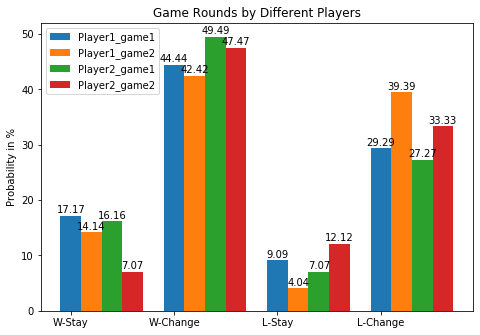

,Win-Stay,Win-Change,Loss-Stay,Loss-Change
count,4.000000,4.000000,4.000000,4.000000
mean,13.635000,45.955000,8.080000,32.320000
std,4.554342,3.140218,3.400167,5.344418
min,7.070000,42.420000,4.040000,27.270000
25%,12.372500,43.935000,6.312500,28.785000
50%,15.150000,45.955000,8.080000,31.310000
75%,16.412500,47.975000,9.847500,34.845000
max,17.170000,49.490000,12.120000,39.390000


In [165]:
df_lst=[df_player1_1,df_player1_2,df_player2_1,df_player2_2]
flatten=flatten_ls(df_lst)

# from flatten list, create small lists for different player and game
l1=flatten[:4]
l2=flatten[4:8]
l3=flatten[8:12]
l4=flatten[12:]
d=[l1,l2,l3,l4]
  
new_df=plot(d)
new_df.describe()

## Current insights

WIN-CHANGE has the highest average are most likely due to the uneven portion between win and loss. As far as I know, there are usually more than 70% win rate in a single game, so players would often shift to different holes since they feel like most of the holes would yield a good result (i.e. a fish). 

## Player's decision based on partner's previous results

In [168]:
def count_stayshift(df_lst):
    # need to set return val of full_operations to return new_df
    lst=[]
    for df in df_lst:
        new=full_operations(df)
        val_stay=new[new['New_Arms_labels']=='Unswitched Arms'].shape[0]
        val_shift=new[new['New_Arms_labels']=='Switched Arms'].shape[0]
        lst.append([val_stay, val_shift])
    return lst

# count_stayshift(df_lst)

prob: [{'W-S': 18.09}, {'W-C': 45.23}, {'L-S': 11.06}, {'L-C': 25.63}, {'W-S': 15.58}, {'W-C': 40.2}, {'L-S': 13.07}, {'L-C': 31.16}]


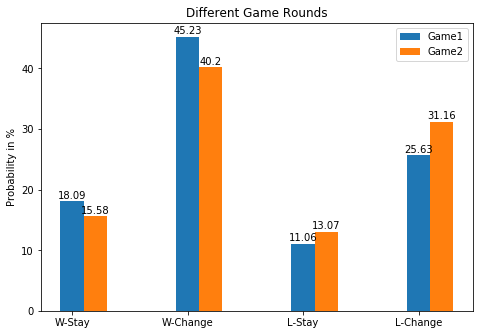

,Win-Stay,Win-Change,Loss-Stay,Loss-Change
count,2.000000,2.000000,2.000000,2.0000
mean,16.835000,42.715000,12.065000,28.3950
std,1.774838,3.556747,1.421285,3.9103
min,15.580000,40.200000,11.060000,25.6300
25%,16.207500,41.457500,11.562500,27.0125
50%,16.835000,42.715000,12.065000,28.3950
75%,17.462500,43.972500,12.567500,29.7775
max,18.090000,45.230000,13.070000,31.1600


In [171]:
df_game1=df[(df['Game Number']=='1')]
df_game2=df[(df['Game Number']=='2')]

df_lst=[df_game1, df_game2]
f=flatten_ls(df_lst)
l1=f[:4]
l2=f[4:]

d=[l1,l2]
df2=plot(d)
df2.describe()
